In [1]:
!pip install razdel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 2.6 MB/s 
     |████████████████████████████████| 8.2 MB 19.7 MB/s 
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=f02d1b28fc76510375c6677352aa1b0680285dd2f4f44929f141504fc5a67a8c
  Stored in directory: /root/.cache/pip/wheels/72/b0/3f/1d95f96ff986c7dfffe46ce2be4062f38ebd04b506c77c81b9
Successfully built docopt


In [4]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 11.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=7875ff4b15380b6625c9d1d32138d0d14eca7961af8f763095c427e16dc56099
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [5]:
import numpy as np

In [6]:
import pandas as pd

Наши новости

In [7]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [8]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [9]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [10]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [12]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [13]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [15]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [16]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [17]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Possible nested set at position 39
  from ipykernel import kernelapp as app


CPU times: user 26 s, sys: 1.12 s, total: 27.1 s
Wall time: 27.2 s


In [18]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 4min 14s, sys: 513 ms, total: 4min 15s
Wall time: 4min 15s


А теперь в 3 строчки обучим нашу модель

In [19]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [20]:
common_dictionary[10]

'ватутин'

Запускаем обучение

In [21]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

CPU times: user 52.5 s, sys: 24.9 s, total: 1min 17s
Wall time: 51.2 s


In [22]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [23]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(1, 0.16255058), (3, 0.7024906), (13, 0.08235453), (20, 0.03211641)]

In [24]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: учёный nn мкс астронавт первый известный звезда
topic_1: день фестиваль всё погода космонавт ночью живой
topic_2: исследование исследователь пациент nn место рост первый
topic_3: большой русский первый увеличение хороший например организм
topic_4: полёт солнечный земля небо nasa находка виза
topic_5: военный сша российский самолёт россия американский корабль
topic_6: самолёт операция земля армия поставка добыча нефть
topic_7: погибнуть район экипаж произойти всё место авария
topic_8: смерть мозг учёный снижение жизнь медведев реальный
topic_9: ракета система космический учёный орбита товар управление
topic_10: украина газ украинский киев инвестиция россия эксперт
topic_11: северный километр война nn сша войско сирия
topic_12: земля москва температура выяснить поверхность центр nn
topic_13: цена клетка рак рейс прогноз исследователь опухоль
topic_14: россия научный проект новый российский банк эксперт
topic_15: млрд рубль руб луна объём бюджет доллар
topic_16: журнал женщина nn

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [25]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [26]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.059094,0.000000,0.000000,0.0,0.000000,0.0,0.0000,0.0,...,0.0,0.036104,0.080777,0.0,0.807476,0.000000,0.0,0.0000,0.0000,0.0
1,4896,0.0,0.405536,0.000000,0.000000,0.0,0.027275,0.0,0.0000,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.4851,0.0616,0.0
2,4897,0.0,0.162503,0.000000,0.702526,0.0,0.000000,0.0,0.0000,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.032117,0.0,0.0000,0.0000,0.0
3,4898,0.0,0.014544,0.448559,0.314326,0.0,0.000000,0.0,0.1266,0.0,...,0.0,0.000000,0.064447,0.0,0.022476,0.000000,0.0,0.0000,0.0000,0.0
4,4899,0.0,0.045193,0.000000,0.000000,0.0,0.000000,0.0,0.0000,0.0,...,0.0,0.000000,0.442539,0.0,0.000000,0.000000,0.0,0.0000,0.0000,0.0


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [27]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [28]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [29]:
doc_dict[293622]

array([0.13215049, 0.        , 0.21182142, 0.        , 0.        ,
       0.        , 0.0126851 , 0.        , 0.        , 0.        ,
       0.        , 0.08685216, 0.01438813, 0.        , 0.        ,
       0.07193322, 0.06141268, 0.15671302, 0.        , 0.        ,
       0.        , 0.        , 0.05069605, 0.07489794, 0.12042833])

In [30]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [31]:
get_user_embedding(user_articles_list)

array([0.        , 0.        , 0.02287767, 0.01358956, 0.        ,
       0.09541455, 0.045086  , 0.00303126, 0.06116724, 0.03641609,
       0.01266475, 0.03845678, 0.00316704, 0.        , 0.20075961,
       0.00218664, 0.00994658, 0.17069892, 0.00712932, 0.06404187,
       0.        , 0.        , 0.02689436, 0.15271311, 0.02237975])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [32]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.022025,0.027141,0.108175,0.000000,0.032827,0.048517,0.018743,0.021975,0.001963,...,0.071352,0.028461,0.074195,0.031637,0.049670,0.002567,0.071665,0.040660,0.075012,0.049352
1,u108690,0.000000,0.011519,0.015640,0.033435,0.012479,0.050116,0.000000,0.043705,0.054656,...,0.021594,0.023268,0.080066,0.051330,0.111854,0.006009,0.030729,0.066831,0.067946,0.037883
2,u108339,0.002434,0.037581,0.014565,0.005417,0.017638,0.110794,0.011673,0.066226,0.027502,...,0.009316,0.000000,0.039214,0.051074,0.083241,0.015212,0.009271,0.078913,0.191675,0.010442


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [33]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [34]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.022025,0.027141,0.108175,0.000000,0.032827,0.048517,0.018743,0.021975,0.001963,...,0.028461,0.074195,0.031637,0.049670,0.002567,0.071665,0.040660,0.075012,0.049352,0
1,u108690,0.000000,0.011519,0.015640,0.033435,0.012479,0.050116,0.000000,0.043705,0.054656,...,0.023268,0.080066,0.051330,0.111854,0.006009,0.030729,0.066831,0.067946,0.037883,1
2,u108339,0.002434,0.037581,0.014565,0.005417,0.017638,0.110794,0.011673,0.066226,0.027502,...,0.000000,0.039214,0.051074,0.083241,0.015212,0.009271,0.078913,0.191675,0.010442,1


In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [36]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [37]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [38]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.10936235, 0.03358726, 0.15962582, 0.26051361, 0.18126894,
       0.03479007, 0.12063261, 0.02678748, 0.02512284, 0.15736877])

In [39]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [40]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.218971, F-Score=0.629, Precision=0.531, Recall=0.771


In [41]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [43]:
import itertools

Confusion matrix, without normalization
[[1588  167]
 [  57  188]]


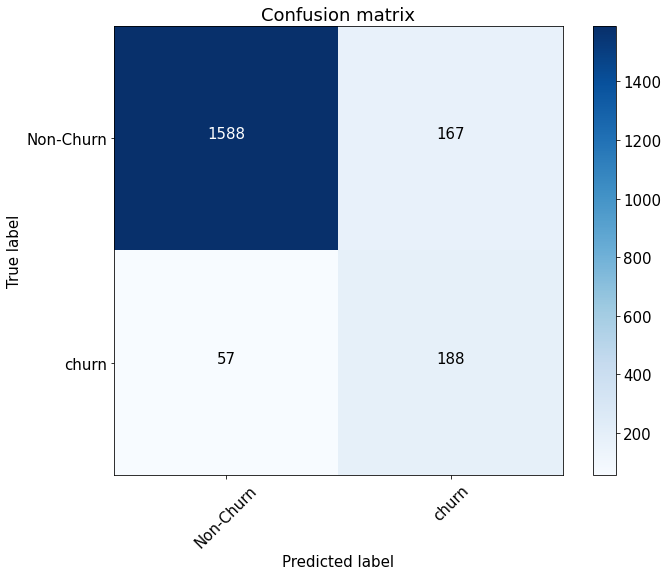

In [44]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [45]:
roc_auc_score(y_test, preds)

0.9335775335775336

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

#### Ссылки

1. http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf
2. https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

### **Домашнее задание**

Модифицируем код функции get_user_embedding таким образом, чтобы считалась медиана

In [46]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [47]:
get_user_embedding(user_articles_list)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.05588394, 0.        , 0.        , 0.04485998, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.17958284,
       0.        , 0.        , 0.14414387, 0.        , 0.        ,
       0.        , 0.        , 0.00901717, 0.06461993, 0.01030634])

In [48]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.000000,0.089279,0.000000,0.014473,0.015270,0.0,0.000000,0.000000,...,0.027415,0.018372,0.036800,0.000000,0.000000,0.0,0.0,0.000000,0.013743,0.017725
1,u108690,0.0,0.000000,0.012395,0.033831,0.000000,0.000000,0.0,0.006422,0.044792,...,0.000000,0.000000,0.070106,0.034829,0.111418,0.0,0.0,0.060956,0.034447,0.010460
2,u108339,0.0,0.025266,0.016288,0.000000,0.000000,0.065072,0.0,0.091071,0.036681,...,0.000000,0.000000,0.015750,0.059269,0.069444,0.0,0.0,0.062482,0.219972,0.000000


In [49]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.000000,0.089279,0.000000,0.014473,0.015270,0.0,0.000000,0.000000,...,0.018372,0.036800,0.000000,0.000000,0.0,0.0,0.000000,0.013743,0.017725,0
1,u108690,0.0,0.000000,0.012395,0.033831,0.000000,0.000000,0.0,0.006422,0.044792,...,0.000000,0.070106,0.034829,0.111418,0.0,0.0,0.060956,0.034447,0.010460,1
2,u108339,0.0,0.025266,0.016288,0.000000,0.000000,0.065072,0.0,0.091071,0.036681,...,0.000000,0.015750,0.059269,0.069444,0.0,0.0,0.062482,0.219972,0.000000,1


In [50]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [51]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [52]:
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.09367044, 0.02912099, 0.25589666, 0.51220927, 0.131018  ,
       0.06837383, 0.07590131, 0.03712244, 0.03294175, 0.17278346])

Рассчитаем Precision, Recall, F_score, roc_auc при расчете median

In [53]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.236691, F-Score=0.743, Precision=0.679, Recall=0.820


In [54]:
roc_auc_score(y_test, preds)

0.9683074597360312

Модифицируем код функции get_user_embedding таким образом, чтобы считался максимум

In [55]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [56]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.132150,0.099018,0.258670,0.000000,0.138664,0.183066,0.099774,0.075852,0.011776,...,0.301351,0.072609,0.214858,0.125363,0.298021,0.015399,0.413509,0.193262,0.347689,0.140231
1,u108690,0.000000,0.069115,0.039892,0.067039,0.044853,0.285255,0.000000,0.179280,0.134065,...,0.115153,0.106507,0.189869,0.131522,0.192313,0.036051,0.169649,0.179257,0.246758,0.134684
2,u108339,0.014602,0.087560,0.031515,0.032504,0.086191,0.282463,0.051338,0.112637,0.046311,...,0.055896,0.000000,0.128968,0.100623,0.156360,0.070887,0.036330,0.222349,0.359590,0.044775


In [57]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.132150,0.099018,0.258670,0.000000,0.138664,0.183066,0.099774,0.075852,0.011776,...,0.072609,0.214858,0.125363,0.298021,0.015399,0.413509,0.193262,0.347689,0.140231,0
1,u108690,0.000000,0.069115,0.039892,0.067039,0.044853,0.285255,0.000000,0.179280,0.134065,...,0.106507,0.189869,0.131522,0.192313,0.036051,0.169649,0.179257,0.246758,0.134684,1
2,u108339,0.014602,0.087560,0.031515,0.032504,0.086191,0.282463,0.051338,0.112637,0.046311,...,0.000000,0.128968,0.100623,0.156360,0.070887,0.036330,0.222349,0.359590,0.044775,1


In [58]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [59]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [60]:
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.01249202, 0.01519373, 0.33061928, 0.1873447 , 0.06678702,
       0.00113648, 0.12562661, 0.00773957, 0.00607054, 0.42150966])

Рассчитаем Precision, Recall, F_score, roc_auc при расчете max

In [61]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.328053, F-Score=0.752, Precision=0.737, Recall=0.767


In [62]:
roc_auc_score(y_test, preds)

0.9696191639048781

Составляем таблицу со значениями метрик для mean, median, max при количестве тем N=25

In [65]:
tabledata = [["mean", 0.531, 0.771, 0.629, 0.934],
         ["mediana", 0.679, 0.820, 0.743, 0.968],
         ["max", 0.737, 0.767, 0.752, 0.969]]

In [67]:
pd.DataFrame(tabledata, columns=["Значение", "Precision","Recall", "F-score", "Roc_auc"])

,Значение,Precision,Recall,F-score,Roc_auc
0,mean,0.531,0.771,0.629,0.934
1,mediana,0.679,0.820,0.743,0.968
2,max,0.737,0.767,0.752,0.969


Вывод: при расчете на максимум все метрики показывают лучшие значения.